In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


In [24]:
# construction du dataframe des features à partir des matchs. Prend bien en compte l'historique d'achat des items.
# features: champion, role, adversaire, item actuel, gold et next item (cible)

from matchup_analysis import build_feature_dataframe_from_parsed
df = build_feature_dataframe_from_parsed(parsed_folder="parsed_matches", champ_data_path="champ_data.csv")
#df.to_csv("features_all_matches.csv", index=False, encoding="utf-8")
print(df.shape)
#df.head()
df.tail()


Récupération des données items via DataDragon...
(99449, 10)


,Champion,Classe du champion,Dégat du champion,Role,Adversaire,Classe de l'adversaire,Dégat de l'adversaire,Gold,Item actuel,Next item
99444,Tristana,Marksman,AD,BOTTOM,Kaisa,Marksman,Mixed,8488,Yun Tal Wildarrows,Infinity Edge
99445,Tristana,Marksman,AD,BOTTOM,Kaisa,Marksman,Mixed,11071,Infinity Edge,Navori Flickerblade
99446,Tristana,Marksman,AD,BOTTOM,Kaisa,Marksman,Mixed,13914,Navori Flickerblade,Lord Dominik's Regards
99447,TahmKench,Tank,AP,UTILITY,Nautilus,Tank,AP,4483,None,Thornmail
99448,TahmKench,Tank,AP,UTILITY,Nautilus,Tank,AP,7248,Thornmail,Unending Despair


In [25]:
from matchup_analysis import build_feature_dataframe
df2 = build_feature_dataframe()
print(df2.shape)
df2.head()

# donne des beaucoups moins bon résultats que le df construit directement par l'historique. Les dimensions ne sont pas les memes non plus
# -> ne prend pas bien en compte l'historique et les lignes dupliquées

(36294, 7)


,Champion,Role,Adversaire,Dégat de l'adversaire,Gold,Item actuel,Next item
0,Aatrox,TOP,Renekton,AD,4589.3,NaN,Spear of Shojin
1,Aatrox,TOP,Mordekaiser,AP,4892.0,NaN,Spear of Shojin
2,Aatrox,TOP,Yone,AD,4591.0,NaN,Eclipse
3,Aatrox,TOP,Renekton,AD,7422.5,Spear of Shojin,Voltaic Cyclosword
4,Aatrox,TOP,Sion,AD,3962.0,NaN,Eclipse


C:\Users\Laurent\AppData\Local\Temp\ipykernel_11576\1002222315.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.values, y=counts.index, palette='viridis')


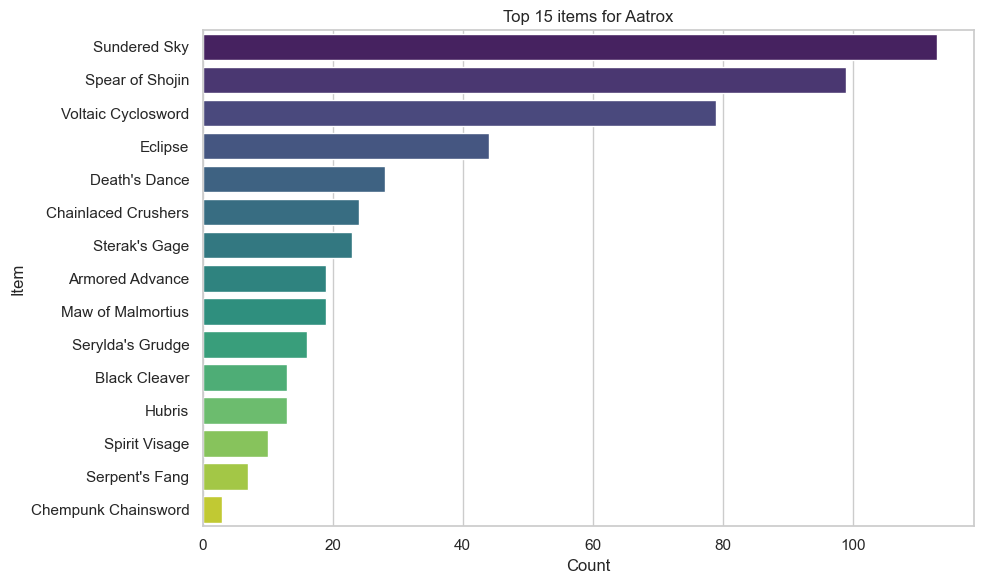

In [26]:
# Fonction de visualisation des top-N items
def plot_top_items(df, champion=None, topn=20, column='Next item'):
    """
    Bar plot des top-N items (globaux ou filtrés par champion).
    """
    sub = df if champion is None else df[df['Champion'] == champion]
    counts = sub[column].value_counts().nlargest(topn)
    plt.figure(figsize=(10,6))
    sns.barplot(x=counts.values, y=counts.index, palette='viridis')
    plt.xlabel('Count')
    plt.ylabel('Item')
    title = f"Top {topn} items"
    if champion: title += f" for {champion}"
    plt.title(title)
    plt.tight_layout()

# Example:
plot_top_items(df, champion='Aatrox', topn=15)

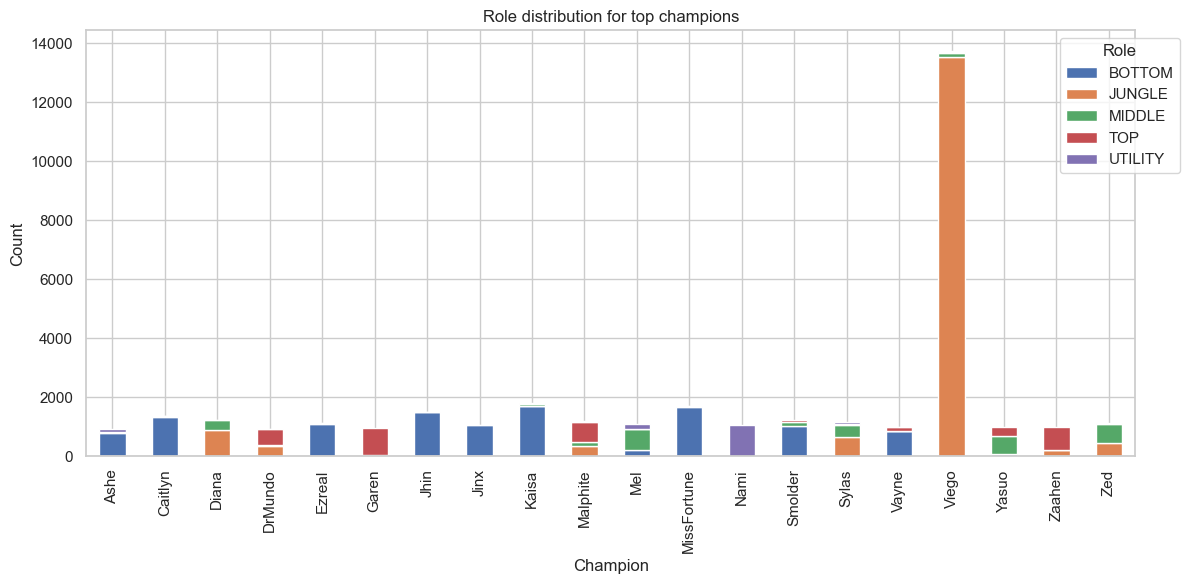

In [27]:
# permet de voir comment se répartissent les rôles pour les champions les plus joués 
# (beaucoup d'adc car peu de champions en bottom et wtf viego)
def plot_role_distribution(df, champion=None, topn=10):
    """
    Affiche la distribution des rôles pour les champions les plus fréquents
    ou pour un champion donné.
    """
    if champion:
        pivot = df[df['Champion'] == champion].groupby('Role')['Next item'].count().sort_values(ascending=False)
        pivot.plot(kind='bar', figsize=(6,4))
        plt.title(f"Role distribution for {champion}")
        plt.ylabel('Count')
    else:
        top_champs = df['Champion'].value_counts().nlargest(topn).index
        sub = df[df['Champion'].isin(top_champs)]
        pivot = sub.groupby(['Champion','Role']).size().unstack(fill_value=0)
        pivot.plot(kind='bar', stacked=True, figsize=(12,6))
        plt.title("Role distribution for top champions")
        plt.ylabel('Count')
        plt.legend(title='Role', bbox_to_anchor=(1.05,1))
    plt.tight_layout()

# Example:
plot_role_distribution(df, topn=20)
# plot_role_distribution(df, champion='Aatrox')

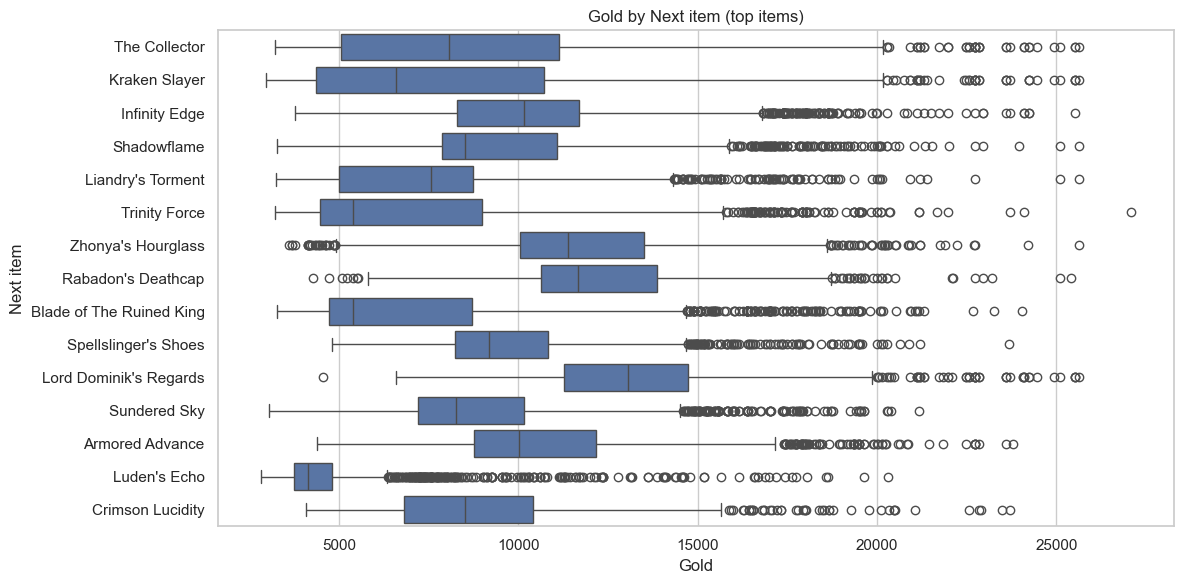

In [28]:
# permet de voir quand sont achetés les items (au début avec les premiers golds ou à la fin)
def plot_gold_by_item(df, item_col='Next item', topn=20):
    top_items = df[item_col].value_counts().nlargest(topn).index
    sub = df[df[item_col].isin(top_items)]
    plt.figure(figsize=(12,6))
    sns.boxplot(y=item_col, x='Gold', data=sub, order=top_items)
    plt.title('Gold by Next item (top items)')
    plt.tight_layout()

# Example:
plot_gold_by_item(df, topn=15)

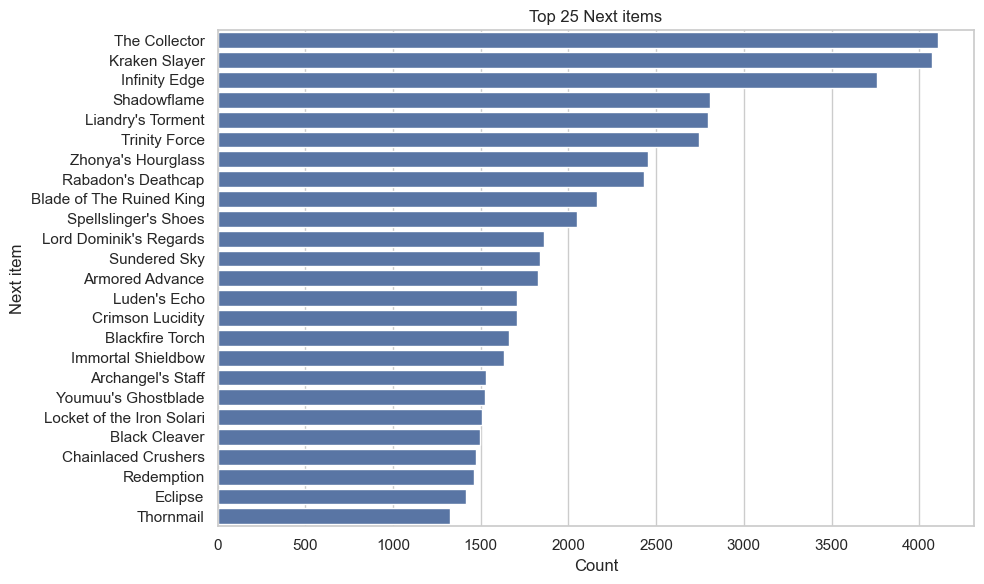

In [29]:
# voir la popularité des items achetés
def plot_next_item_counts(df, topn=30):
    counts = df['Next item'].value_counts().nlargest(topn)
    plt.figure(figsize=(10,6))
    sns.barplot(x=counts.values, y=counts.index)
    plt.title(f'Top {topn} Next items')
    plt.xlabel('Count')
    plt.tight_layout()

# Example:
plot_next_item_counts(df, topn=25)

In [30]:
# pas fou, on peut voir une corrélation entre manamune et ez par exemple, mais bcp trop grand pour l'instant

def plot_correlation_heatmap(df, categorical_cols=None, numeric_cols=None, encode='onehot', method='pearson', topk_categories=50):
    """
    - encode: 'onehot' ou 'label'
    - method: 'pearson' or 'spearman'
    - topk_categories: si onehot, garder top-K valeurs par catégorie (remplacer le reste par 'OTHER') pour éviter explosion
    """
    df = df.copy()

    if numeric_cols is None:
        # essayer de détecter colonnes numériques
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    if categorical_cols is None:
        categorical_cols = [c for c in df.columns if c not in numeric_cols]

    # Prepare categorical subset
    cat_df = pd.DataFrame(index=df.index)
    for c in categorical_cols:
        if encode == 'onehot':
            # reduce cardinality
            top_vals = df[c].value_counts().nlargest(topk_categories).index
            series = df[c].where(df[c].isin(top_vals), other='OTHER').fillna('UNKNOWN')
            dummies = pd.get_dummies(series, prefix=c)
            cat_df = pd.concat([cat_df, dummies], axis=1)
        else:  # label
            series = df[c].fillna('UNKNOWN').astype(str)
            le = pd.factorize(series)[0]  # faster than sklearn for quick viz
            cat_df[c] = le

    num_df = df[numeric_cols].copy()

    # combine
    combined = pd.concat([num_df, cat_df], axis=1).fillna(0)

    # compute correlation matrix
    corr = combined.corr(method=method)

    # plot heatmap (size driven by number of columns)
    plt.figure(figsize=(min(20, 0.25*corr.shape[0]), min(20, 0.25*corr.shape[1])))
    sns.heatmap(corr, cmap='RdBu_r', center=0, vmin=-1, vmax=1, linewidths=.5)
    plt.title(f'Correlation heatmap ({method}) over numeric + encoded categorical features')
    plt.tight_layout()

# Example:
# plot_correlation_heatmap(df, categorical_cols=['Champion','Role','Adversaire','Item actuel','Next item'], numeric_cols=['Gold'], encode='onehot', method='pearson', topk_categories=40)

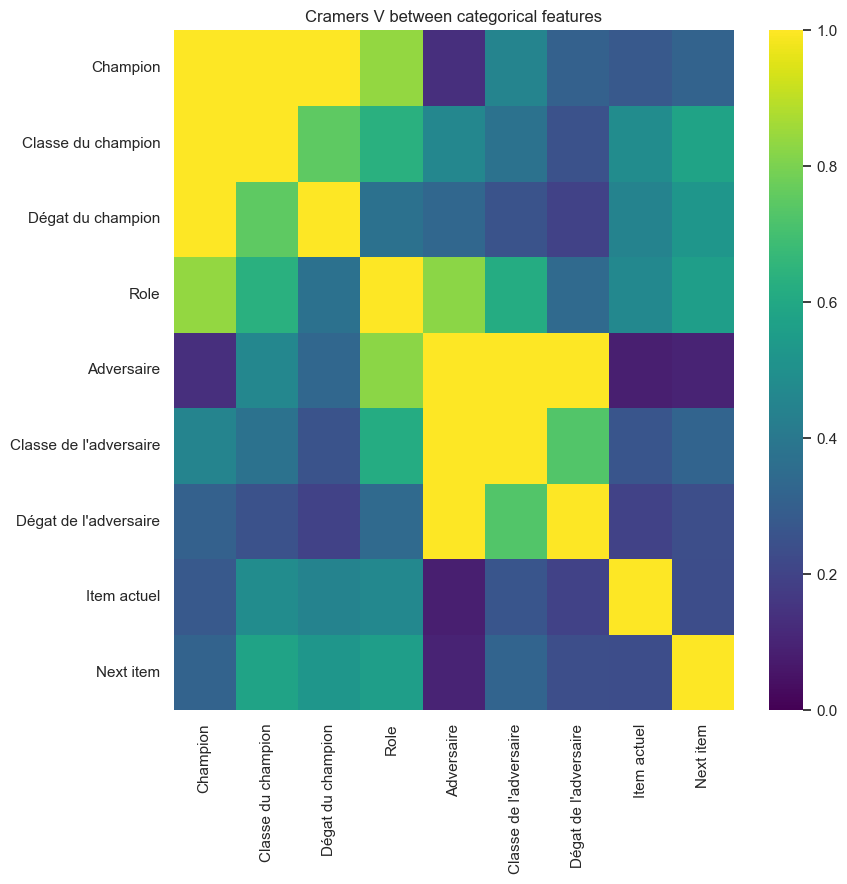

In [31]:
import scipy.stats as ss

#Heatmap de corrélation de variables catégorielles
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1),(rcorr-1)+1e-9))

def category_heatmap(df, cats, topk=30):
    cats = list(cats)
    m = np.zeros((len(cats), len(cats)))
    for i,a in enumerate(cats):
        for j,b in enumerate(cats):
            m[i,j] = cramers_v(df[a].fillna('NA'), df[b].fillna('NA'))
    plt.figure(figsize=(len(cats), len(cats)))
    sns.heatmap(m, xticklabels=cats, yticklabels=cats, cmap='viridis', vmin=0, vmax=1)
    plt.title("Cramers V between categorical features")
    plt.tight_layout()

# Example:
category_heatmap(df, ['Champion','Classe du champion', 'Dégat du champion', 'Role', 'Adversaire', 'Classe de l\'adversaire', 'Dégat de l\'adversaire','Item actuel', 'Next item'], topk=30)

Formulation du problème

Tâche : classification multi-classe — prédire 1 item parmi N (N = nombre d'items finals observés).

Entrée (contexte) possible : séquence d'items déjà achetés (ou uniquement dernier item), champion joué, champion adverse, rôle (lane), gold et possiblement plus

Sortie : probas sur le vocabulaire d'items; on utilise top-k accuracy (k=1,3,5) comme métriques principales.

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

# Prépare les colonnes et nettoie les valeurs manquantes comme lors de l'entraînement
df = df.dropna(subset=["Next item"])
df['Item actuel'] = df['Item actuel'].fillna('None')
df['Role'] = df['Role'].fillna('Unknown')
df['Adversaire'] = df['Adversaire'].fillna('Unknown')

FEATURE_COLS = ['Champion','Classe du champion', 'Dégat du champion', 'Role', 'Adversaire', 'Classe de l\'adversaire', 'Dégat de l\'adversaire','Item actuel', 'Gold']
X = df[FEATURE_COLS]
y = df['Next item']

# encoder la cible
le_y = LabelEncoder()
y_enc = le_y.fit_transform(y)
print("Nombre de classes (items):", len(le_y.classes_))

# encoder catégoriels + scaler numérique (compatible scikit-learn versions)
categorical_cols = ['Champion','Classe du champion', 'Dégat du champion', 'Role', 'Adversaire', 'Classe de l\'adversaire', 'Dégat de l\'adversaire','Item actuel']
#categorical_cols = ['Champion', 'Role', 'Adversaire', 'Item actuel']  #anciennement
numeric_cols = ['Gold']

try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

preprocessor = ColumnTransformer(transformers=[
    ('cat', ohe, categorical_cols),
    ('num', StandardScaler(), numeric_cols)
])

print("Fitting preprocessor...")
X_proc = preprocessor.fit_transform(X)
print("X_proc shape:", X_proc.shape)

# split
X_train, X_test, y_train, y_test = train_test_split(
    X_proc, y_enc, test_size=0.20, random_state=42, stratify=y_enc
)

# train
clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42, class_weight='balanced')
print("Training RandomForest...")
clf.fit(X_train, y_train)
print("Training done.")

Nombre de classes (items): 107
Fitting preprocessor...
X_proc shape: (99449, 480)
Training RandomForest...
Training done.


In [33]:
def top_k_accuracy(clf, X, y, k=3):
    probs = clf.predict_proba(X)
    topk = np.argsort(probs, axis=1)[:, ::-1][:, :k]
    return np.mean([y[i] in topk[i] for i in range(len(y))])

In [34]:
print("Top-1:", top_k_accuracy(clf, X_test, y_test, k=1))
print("Top-3:", top_k_accuracy(clf, X_test, y_test, k=3))
print("Top-5:", top_k_accuracy(clf, X_test, y_test, k=5))


Top-1: 0.4234791352438411
Top-3: 0.7006535947712418
Top-5: 0.7908999497234791


In [35]:
os.makedirs('models', exist_ok=True)
joblib.dump({'model': clf, 'preprocessor': preprocessor, 'label_encoder': le_y, 'feature_columns': FEATURE_COLS},
            'models/item_rf_pipeline.pkl')
print("Pipeline saved to models/item_rf_pipeline.pkl")

Pipeline saved to models/item_rf_pipeline.pkl


In [36]:
pipeline = {'model': clf, 'preprocessor': preprocessor, 'label_encoder': le_y, 'feature_columns': FEATURE_COLS}

def predict_topk_row(input_row, k=5, pipeline=pipeline):
    model = pipeline['model']
    preprocessor = pipeline['preprocessor']
    le = pipeline['label_encoder']
    feature_cols = pipeline['feature_columns']

    # Normalisation des valeurs manquantes
    row = {c: input_row.get(c, None) for c in feature_cols}
    row['Item actuel'] = row.get('Item actuel') or 'None'
    row['Role'] = row.get('Role') or 'Unknown'
    row['Adversaire'] = row.get('Adversaire') or 'Unknown'
    if row.get('Gold') is None:
        row['Gold'] = np.nan

    X = pd.DataFrame([row], columns=feature_cols)
    X_proc = preprocessor.transform(X)
    probs = model.predict_proba(X_proc)[0]
    top_idx = np.argsort(probs)[::-1][:k]
    top_items = le.inverse_transform(top_idx)
    top_probs = probs[top_idx]
    return list(zip(top_items, top_probs))

In [37]:
# Exemple (à chaque fois bien préciser toutes les features demandées) :

ex1 = {"Champion":"Aatrox","Classe du champion":"Fighter","Dégat du champion":"AD","Role":"TOP","Adversaire":"Renekton","Classe de l'adversaire":"Fighter","Dégat de l'adversaire":"AD","Item actuel":"None","Gold":1200}
print("ex1 :",predict_topk_row(ex1, k=5))

ex2 = {"Champion":"Aatrox","Classe du champion":"Fighter","Dégat du champion":"AD","Role":"TOP","Adversaire":"Renekton","Classe de l'adversaire":"Fighter","Dégat de l'adversaire":"AD","Item actuel":"Spear of Shojin","Gold":1200}
print("ex2 :",predict_topk_row(ex2, k=5))

ex3 = {"Champion":"Aatrox","Classe du champion":"Fighter","Dégat du champion":"AD","Role":"TOP","Adversaire":"Renekton","Classe de l'adversaire":"Fighter","Dégat de l'adversaire":"AD","Item actuel":"Sundered Sky","Gold":1200}
print("ex3 :",predict_topk_row(ex3, k=5))

"""
ex1 = {"Champion":"Aatrox","Role":"TOP","Adversaire":"Renekton","Item actuel":"None","Gold":1200}
print("ex1 :",predict_topk_row(ex1, k=5))

ex2 = {"Champion":"Aatrox","Role":"TOP","Adversaire":"Renekton","Item actuel":"Spear of Shojin","Gold":1200}
print("ex2 :",predict_topk_row(ex2, k=5))

ex3 = {"Champion":"Aatrox","Role":"TOP","Adversaire":"Renekton","Item actuel":"Sundered Sky","Gold":1200}
print("ex3 :",predict_topk_row(ex3, k=5)) """

ex1 : [('Spear of Shojin', np.float64(0.545)), ('Sundered Sky', np.float64(0.25)), ('Eclipse', np.float64(0.12)), ("Serpent's Fang", np.float64(0.03)), ('Frozen Heart', np.float64(0.015))]
ex2 : [('Voltaic Cyclosword', np.float64(0.435)), ('Sundered Sky', np.float64(0.2)), ('Spear of Shojin', np.float64(0.155)), ('Eclipse', np.float64(0.04)), ("Winter's Approach", np.float64(0.02))]
ex3 : [('Spear of Shojin', np.float64(0.265)), ('Sundered Sky', np.float64(0.13)), ("Serpent's Fang", np.float64(0.12)), ('Eclipse', np.float64(0.105)), ('Voltaic Cyclosword', np.float64(0.085))]


'\nex1 = {"Champion":"Aatrox","Role":"TOP","Adversaire":"Renekton","Item actuel":"None","Gold":1200}\nprint("ex1 :",predict_topk_row(ex1, k=5))\n\nex2 = {"Champion":"Aatrox","Role":"TOP","Adversaire":"Renekton","Item actuel":"Spear of Shojin","Gold":1200}\nprint("ex2 :",predict_topk_row(ex2, k=5))\n\nex3 = {"Champion":"Aatrox","Role":"TOP","Adversaire":"Renekton","Item actuel":"Sundered Sky","Gold":1200}\nprint("ex3 :",predict_topk_row(ex3, k=5)) '

C:\Users\Laurent\AppData\Local\Temp\ipykernel_11576\1822901584.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


Index(['None', 'Kraken Slayer', 'The Collector', 'Trinity Force',
       'Infinity Edge', 'Liandry's Torment', 'Blade of The Ruined King',
       'Shadowflame', 'Luden's Echo', 'Blackfire Torch'],
      dtype='object', name='Item actuel')


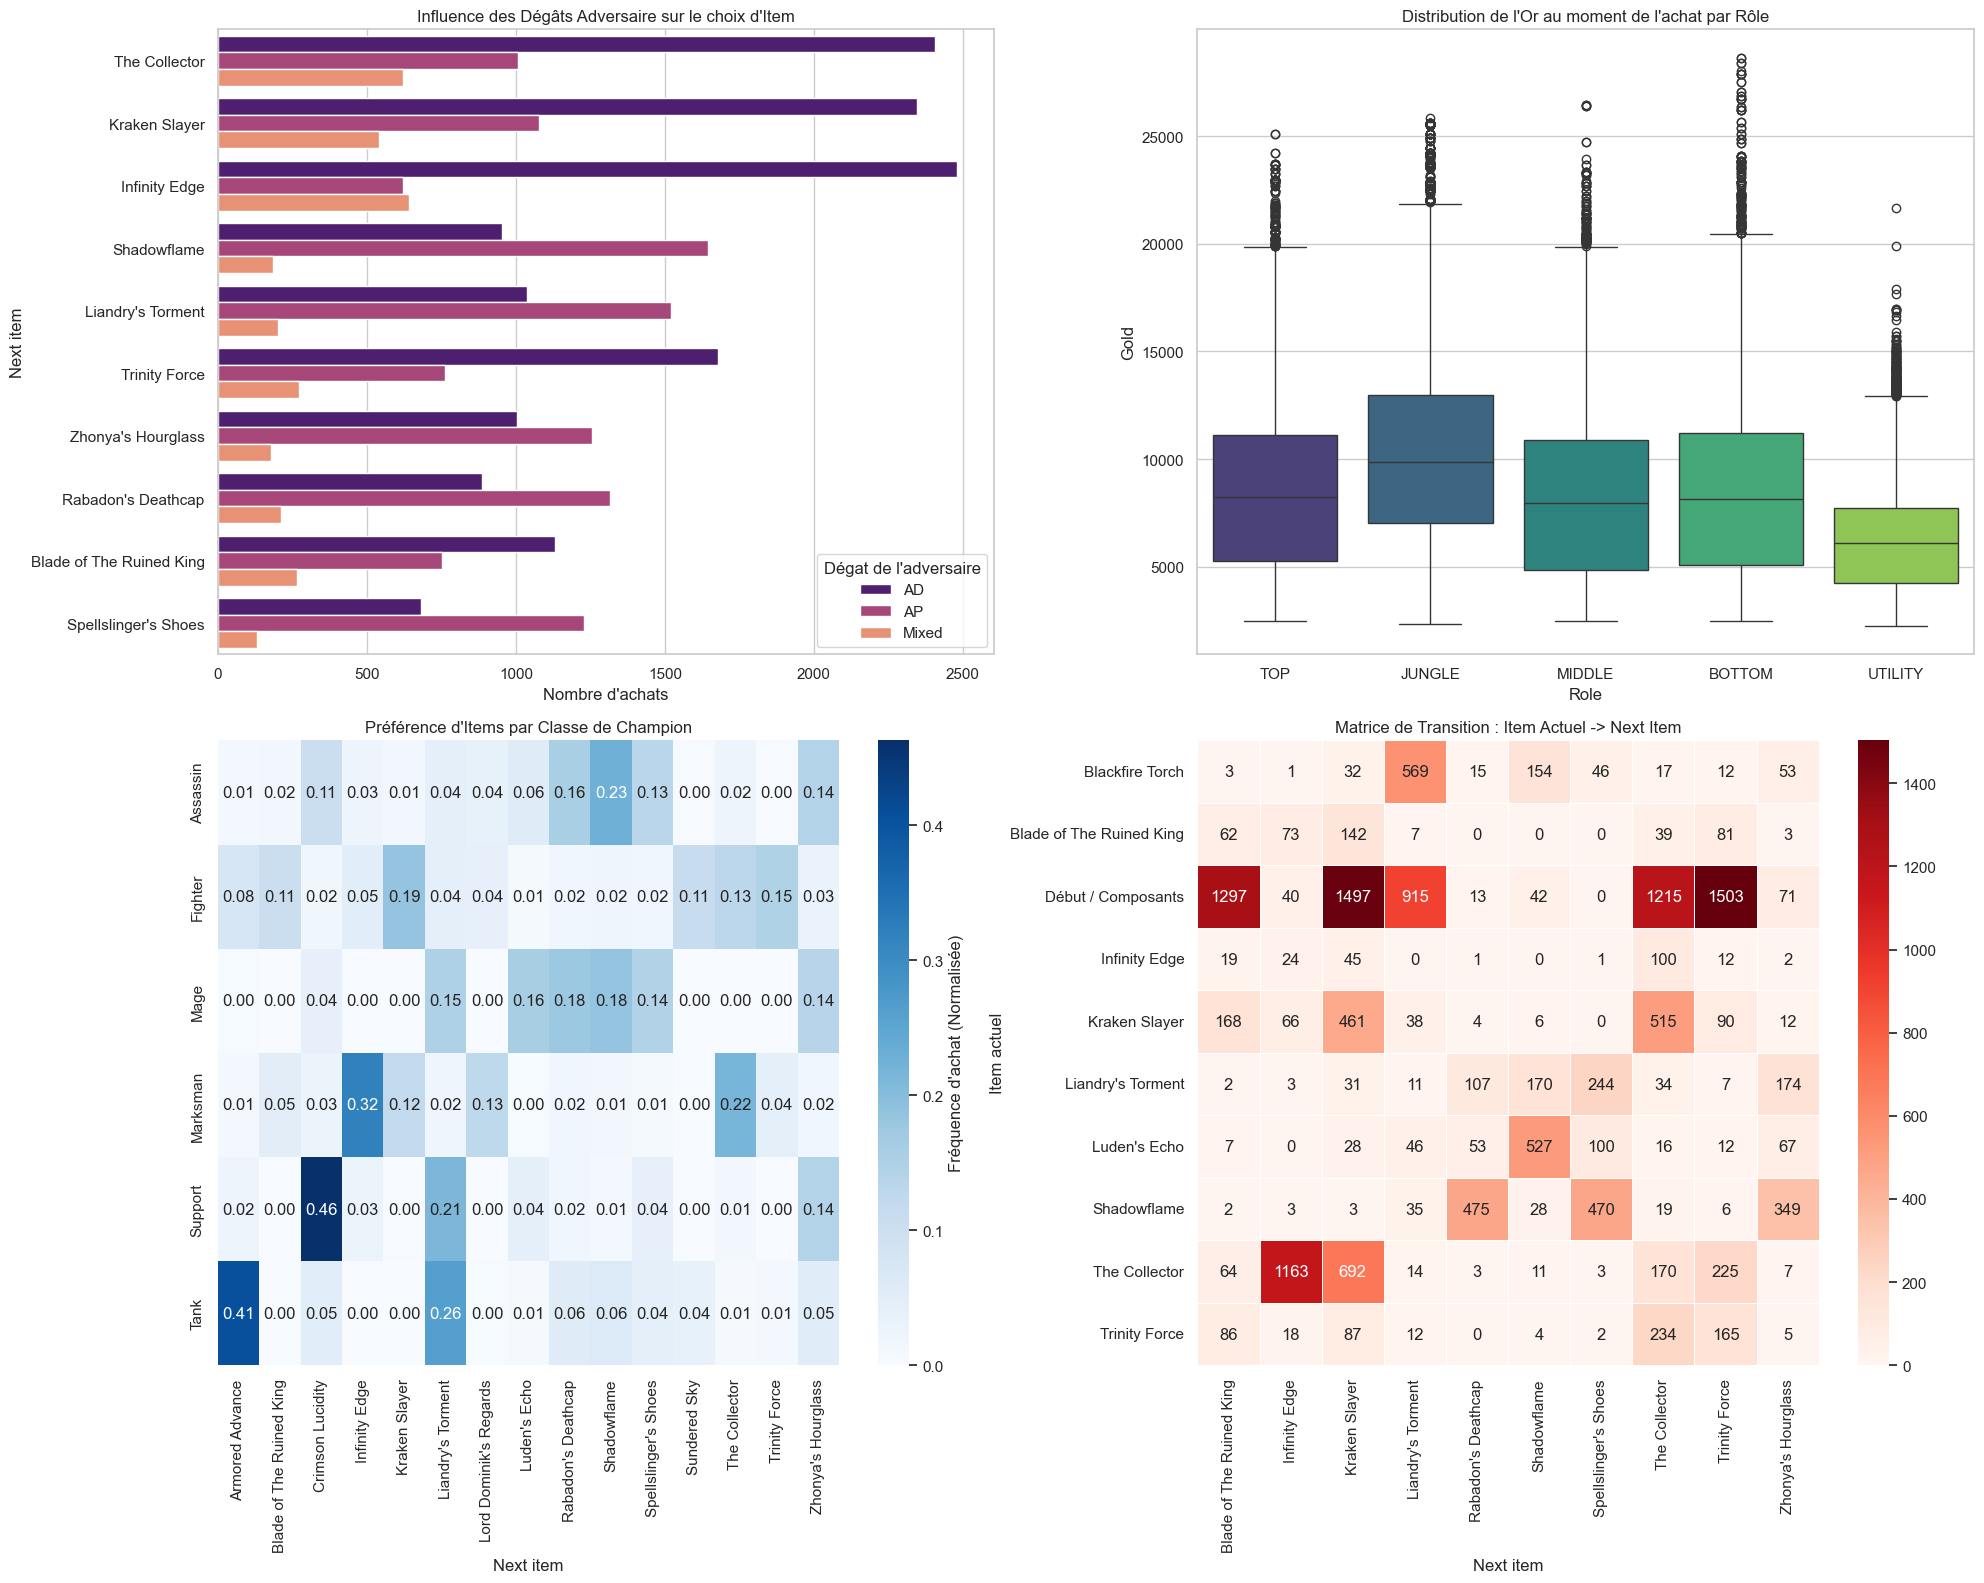

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Configuration du style
sns.set_theme(style="whitegrid")

def plot_advanced_eda(df):
    """
    Génère 4 graphiques avancés pour comprendre les relations entre features.
    """
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # --- 1. Counter-Building : Top Items selon les Dégâts de l'Adversaire ---
    # On prend les 10 items les plus fréquents pour ne pas surcharger le graphe
    top_items = df['Next item'].value_counts().nlargest(10).index
    df_top = df[df['Next item'].isin(top_items)]
    
    sns.countplot(
        data=df_top, 
        y='Next item', 
        hue='Dégat de l\'adversaire', 
        order=top_items,
        ax=axes[0, 0],
        palette="magma"
    )
    axes[0, 0].set_title("Influence des Dégâts Adversaire sur le choix d'Item")
    axes[0, 0].set_xlabel("Nombre d'achats")

    # --- 2. Distribution de l'Or par Rôle ---
    sns.boxplot(
        data=df, 
        x='Role', 
        y='Gold', 
        ax=axes[0, 1],
        palette="viridis"
    )
    axes[0, 1].set_title("Distribution de l'Or au moment de l'achat par Rôle")
    
    # --- 3. Heatmap : Classe du Champion vs Items (Normalisée) ---
    # On regarde les items fréquents croisés avec les classes
    top_items_heatmap = df['Next item'].value_counts().nlargest(15).index
    df_heatmap = df[df['Next item'].isin(top_items_heatmap)]
    
    # Création de la matrice de contingence (normalisée par ligne pour voir les préférences par classe)
    crosstab = pd.crosstab(df_heatmap['Classe du champion'], df_heatmap['Next item'])
    crosstab_norm = crosstab.div(crosstab.sum(axis=1), axis=0)
    
    sns.heatmap(
        crosstab_norm, 
        annot=True, 
        fmt=".2f", 
        cmap="Blues", 
        ax=axes[1, 0],
        cbar_kws={'label': 'Fréquence d\'achat (Normalisée)'}
    )
    axes[1, 0].set_title("Préférence d'Items par Classe de Champion")
    axes[1, 0].set_ylabel("")

    # --- 4. Matrice de Transition (Item Actuel -> Next Item) ---
    # On se concentre sur les items "Actuels" non nuls et fréquents
    valid_current = df['Item actuel'].value_counts().nlargest(10).index
    print(valid_current)
    # On exclut "None" si présent, ou on le garde pour voir le premier achat
    df_trans = df[df['Item actuel'].isin(valid_current) & df['Next item'].isin(top_items)]
    # Remplacer 'None' par un label plus clair dans une copie du dataframe
    df_trans_plot = df_trans.copy()
    df_trans_plot['Item actuel'] = df_trans_plot['Item actuel'].replace('None', 'Début / Composants')

    # Recalculer la matrice avec le nouveau nom
    trans_matrix = pd.crosstab(df_trans_plot['Item actuel'], df_trans_plot['Next item'])


    
    sns.heatmap(
        trans_matrix, 
        cmap="Reds", 
        linewidths=.5,
        ax=axes[1, 1],
        annot=True,    # <--- Ajoute les chiffres
        fmt="d"        # <--- Formate comme des entiers (pas de notation scientifique)
    )
    axes[1, 1].set_title("Matrice de Transition : Item Actuel -> Next Item")
    
    plt.tight_layout()
    plt.show()

# Lancer les visualisations
# Assurez-vous que 'df' est bien votre dataframe chargé
plot_advanced_eda(df)